# BIRCH

## Introduction

In this notebook I developed a first implementation of the BIRCH algorithm described in the paper "BIRCH: An Efficient Data Clustering Method for Very Large Databases". The implementation has been tested on the `iris` toy dataset and compared with other clustering algorithms.

In [1]:
from sklearn import datasets # to get the iris dataset
import matplotlib.pyplot as plt
import numpy as np

import CFTree_methods # local file
import side_methods # local file

iris = datasets.load_iris()

# Print the contents of the iris dataset
print("Keys of iris dataset:", iris.keys)
print("\nDescription of dataset:\n", iris.DESCR)
print("\nFeature names:", iris.feature_names) # type: <class 'list'>; len(iris.feature_names) is 4; iris.feature_names[0] contains a string
print("\nTarget names:", iris.target_names) # type: <class 'numpy.ndarray'>; shape: (3,); iris.target_names[0] contains a string
print("\nFirst 5 rows of data:\n", iris.data[:5]) # iris.data has type: <class 'numpy.ndarray'>; shape: (150, 4)
print("\nFirst 5 target values:", iris.target[:5]) # iris.taget has type: <class 'numpy.ndarray'>; shape: (150,)

Keys of iris dataset: <built-in method keys of Bunch object at 0x000001ECA5BEB930>

Description of dataset:
 .. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    pet

In [2]:
def plot2D_iris(data_x, name_x, data_y, name_y, target, colors_on, predict_on):
    _, ax = plt.subplots()
    if colors_on == True and predict_on == False:
        colors = ['red', 'green', 'blue']
    elif colors_on == False and predict_on == False:
        colors = ['grey', 'grey', 'grey']
    else: # if predict_on == True
        colors = ['pink', 'orange', 'cyan']
    
    cmap = plt.cm.colors.ListedColormap(colors)
    scatter = ax.scatter(data_x, data_y, c=target, cmap=cmap)
    ax.set(xlabel=name_x, ylabel=name_y)

    if colors_on == True and predict_on == False:
        show = ax.legend(
            scatter.legend_elements()[0], iris.target_names, loc="lower right", title="Classes"
        )
    else: # (colors_on == False and predict_on == False) or predict_on == True
        invisible_handles = [plt.Line2D([0], [0], color='w') for _ in iris.target_names]
        noShow = ax.legend(
            invisible_handles, iris.target_names, loc="lower right", title="Classes"
        )


def plot3D_iris(data_x_num, name_x_num, data_x_den, name_x_den, data_y_num, name_y_num, data_y_den, name_y_den, data_z, name_z, target, colors_on, predict_on):

    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')

    x = data_x_num / data_x_den  # first feature
    y = data_y_num / data_y_den  # second feature
    z = data_z # third feature  

    if colors_on == True and predict_on == False:
        colors = ['red', 'green', 'blue']
    elif colors_on == False and predict_on == False:
        colors = ['grey', 'grey', 'grey']
    else: # if predict_on == True
        colors = ['pink', 'orange', 'cyan']

    cmap = plt.cm.colors.ListedColormap(colors)
    scatter = ax.scatter(x, y, z, c=target, cmap=cmap)

    ax.set_xlabel(f"{name_x_num} / {name_x_den}", labelpad=5)
    ax.set_ylabel(f"{name_y_num} / {name_y_den}", labelpad=5)
    ax.set_zlabel(name_z, labelpad=5)

    legend_labels = iris.target_names
    legend_handles = []

    if colors_on == True and predict_on == False:
        for i in range(len(legend_labels)):
            handle = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[i], markersize=10)
            legend_handles.append(handle)
    else:  # (colors_on == False and predict_on == False) or predict_on == True
        for i in range(len(legend_labels)):
            handle = plt.Line2D([0], [0], marker='o', color='w')
            legend_handles.append(handle)

    ax.legend(legend_handles, legend_labels, title="Classes", loc="upper right")
    ax.view_init(40, 10)

    plt.show()

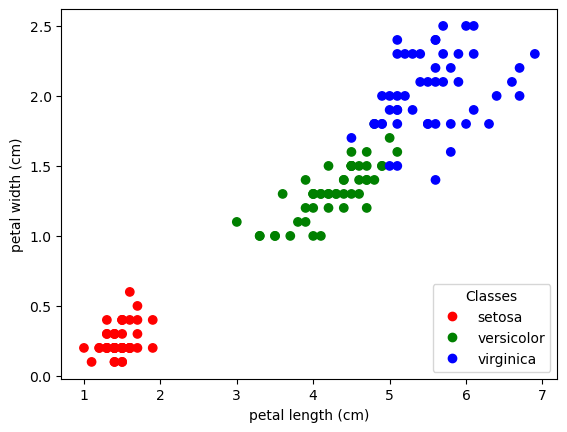

In [3]:
feature_x = 2
feature_y = 3

plot2D_iris(data_x = iris.data[:, feature_x], name_x = iris.feature_names[feature_x], data_y = iris.data[:, feature_y], name_y = iris.feature_names[feature_y],
            target = iris.target, colors_on = True, predict_on = False)

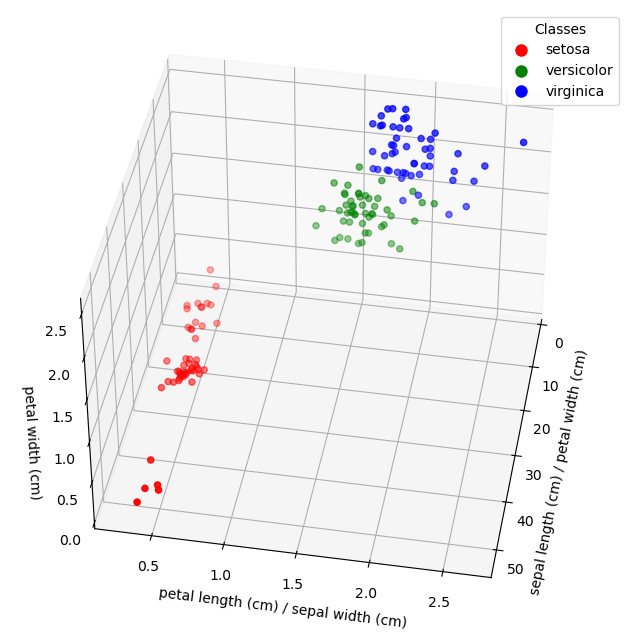

In [4]:
feature_x_num = 0
feature_x_den = 3
feature_y_num = 2
feature_y_den = 1
feature_z = 3

plot3D_iris(data_x_num = iris.data[:, feature_x_num], name_x_num = iris.feature_names[feature_x_num], data_x_den = iris.data[:, feature_x_den], name_x_den = iris.feature_names[feature_x_den], 
            data_y_num = iris.data[:, feature_y_num], name_y_num = iris.feature_names[feature_y_num], data_y_den = iris.data[:, feature_y_den], name_y_den = iris.feature_names[feature_y_den],
            data_z = iris.data[:, feature_z], name_z = iris.feature_names[feature_z], target = iris.target, colors_on = True, predict_on = False)


## Implementation of BIRCH

### Phase 1

In [5]:
#
# Phase 1: Load into memory by building a CF tree
#

tree = CFTree_methods.CFTree(branching_factor_B = 3, threshold_T = 0.05, max_num_entries_leafnode_L = 2, distance_metric = side_methods.average_intercluster_distance_D2)

for i in range(len(iris.data)):
    tree.insert(iris.data[i])

print("\n\nDISPLAYING CF TREE:\n")
CFTree_methods.display_tree(tree.root)



DISPLAYING CF TREE:

Depth 0: Internal Node:
  N: 150
  LS: [876.5 458.6 563.7 179.9]
  SS: 9539.29

  Child 0:
    Depth 1: Internal Node:
      N: 52
      LS: [260.2 175.8  79.9  14.3]
      SS: 2049.52

      Child 0:
        Depth 2: Internal Node:
          N: 25
          LS: [118.5  76.8  38.7   6.6]
          SS: 873.0400000000001

          Child 0:
            Depth 3: Internal Node:
              N: 5
              LS: [22.  14.4  6.4  1. ]
              SS: 147.22

              Child 0:
                Depth 4: Internal Node:
                  N: 5
                  LS: [22.  14.4  6.4  1. ]
                  SS: 147.22

                  Child 0:
                    Depth 5: Internal Node:
                      N: 1
                      LS: [4.5 2.3 1.3 0.3]
                      SS: 27.32

                      Child 0:
                        Depth 6: Leaf Node:
                          N: 1
                          LS: [4.5 2.3 1.3 0.3]
                          

### Phase 2

In [6]:
#
# Phase 2: Condense into desirable range by building a smaller CF tree
#

# NOT IMPLEMENTED

### Phase 3

In [7]:
#
# Phase 3: Global Clustering
#

# Use agglomerative hierarchical clustering algorithm by applying it directly to the subclusters represented by their CF vectors; use D2 distance metric

# Get the list list_leafnodes of the leafnodes and the list list_subclusters containing all the subclusters (each subcluster is a collection of datapoints)

a_leafnode = tree.get_a_leafnode()
list_leafnodes = []
list_leafnodes.append(a_leafnode)

list_subclusters = []
for subcluster_i in range(len(a_leafnode.CF_list)):
    list_subclusters.append(a_leafnode.CF_list[subcluster_i])

# Get all the prev leafnodes
current_leafnode = a_leafnode
while current_leafnode.pointer_prev is not None:
    current_leafnode = current_leafnode.pointer_prev
    list_leafnodes.append(current_leafnode)
    for subcluster_i in range(len(current_leafnode.CF_list)):
        list_subclusters.append(current_leafnode.CF_list[subcluster_i])
    
# Get all the next leafnodes
current_leafnode = a_leafnode
while current_leafnode.pointer_next is not None:
    current_leafnode = current_leafnode.pointer_next
    list_leafnodes.append(current_leafnode)
    for subcluster_i in range(len(current_leafnode.CF_list)):
        list_subclusters.append(current_leafnode.CF_list[subcluster_i])

# Here list_subclusters is a list made of elements [CF, Subcluster]. It contains all the subclusters from the CFTree

# Get result_clusters, a dictionary where the key indicates the index of the cluster and the value is an array of the associated datapoints
num_clusters = 3
result_clusters = side_methods.hierarchical_clustering(list_subclusters, num_clusters)


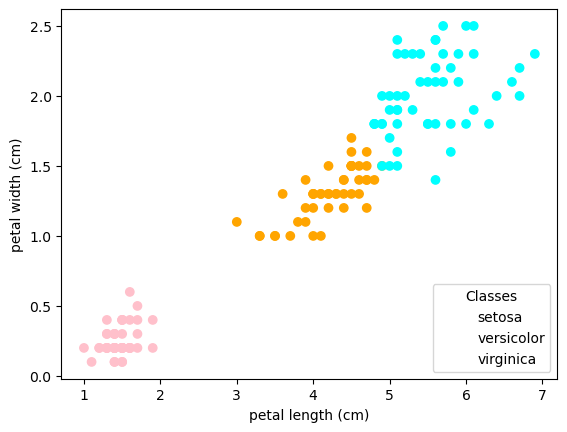

In [8]:
data_x = []
feature_x = 2
data_y = []
feature_y = 3
target = []

for cluster, array_points in result_clusters.items():
    for point in array_points:
        data_x.append(point[feature_x])
        data_y.append(point[feature_y])
        target.append(cluster)

data_x = np.array(data_x)
data_y = np.array(data_y)
target = np.array(target)

plot2D_iris(data_x = data_x, name_x = iris.feature_names[feature_x], data_y = data_y, name_y = iris.feature_names[feature_y],
            target = target, colors_on = True, predict_on = True)

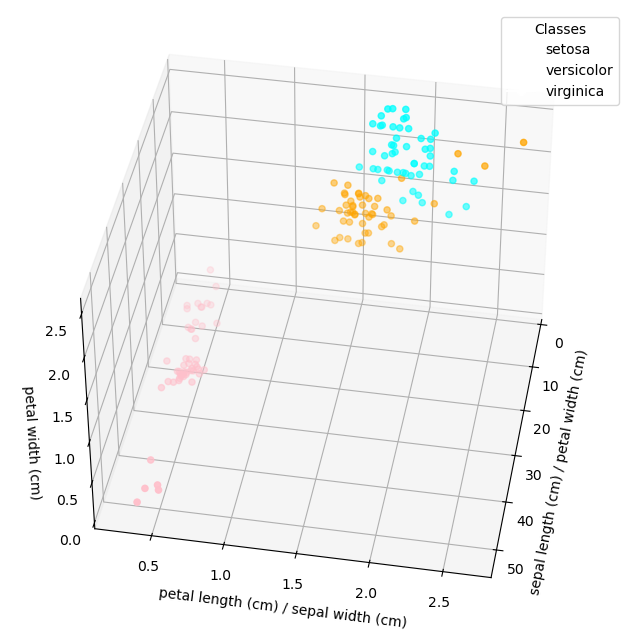

In [9]:
data_x_num = []
feature_x_num = 0
data_x_den = []
feature_x_den = 3

data_y_num = []
feature_y_num = 2
data_y_den = []
feature_y_den = 1

data_z = []
feature_z = 3

target = []

for cluster, array_points in result_clusters.items():
    for point in array_points:
        data_x_num.append(point[feature_x_num])
        data_x_den.append(point[feature_x_den])
        data_y_num.append(point[feature_y_num])
        data_y_den.append(point[feature_y_den])
        data_z.append(point[feature_z])
        target.append(cluster)

data_x_num = np.array(data_x_num)
data_x_den = np.array(data_x_den)
data_y_num = np.array(data_y_num)
data_y_den = np.array(data_y_den)
data_z = np.array(data_z)
target = np.array(target)

plot3D_iris(data_x_num = data_x_num, name_x_num = iris.feature_names[feature_x_num], data_x_den = data_x_den, name_x_den = iris.feature_names[feature_x_den], 
            data_y_num = data_y_num, name_y_num = iris.feature_names[feature_y_num], data_y_den = data_y_den, name_y_den = iris.feature_names[feature_y_den],
            data_z = data_z, name_z = iris.feature_names[feature_z], target = iris.target, colors_on = True, predict_on = True)

### Phase 4

In [21]:
#
# Phase 4: Cluster Refining
#

# Use the centroids produced by Phase 3 as seeds and redistribute the datapoints to the closest seed

num_iterations = 1
new_result_clusters = side_methods.redistribute_datapoints(result_clusters, num_iterations)

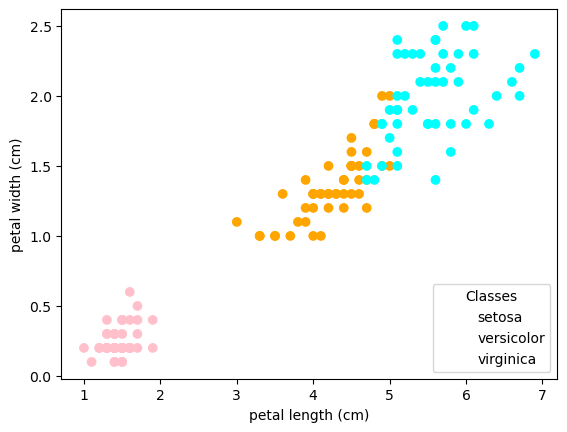

In [22]:
data_x = []
feature_x = 2
data_y = []
feature_y = 3
target = []

for cluster, array_points in new_result_clusters.items():
    for point in array_points:
        data_x.append(point[feature_x])
        data_y.append(point[feature_y])
        target.append(cluster)

data_x = np.array(data_x)
data_y = np.array(data_y)
target = np.array(target)

plot2D_iris(data_x = data_x, name_x = iris.feature_names[feature_x], data_y = data_y, name_y = iris.feature_names[feature_y],
            target = target, colors_on = True, predict_on = True)

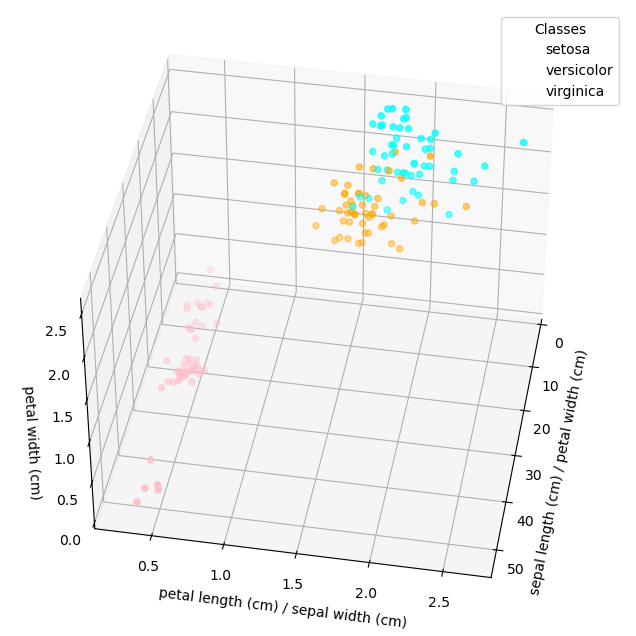

In [23]:
data_x_num = []
feature_x_num = 0
data_x_den = []
feature_x_den = 3

data_y_num = []
feature_y_num = 2
data_y_den = []
feature_y_den = 1

data_z = []
feature_z = 3

target = []

for cluster, array_points in new_result_clusters.items():
    for point in array_points:
        data_x_num.append(point[feature_x_num])
        data_x_den.append(point[feature_x_den])
        data_y_num.append(point[feature_y_num])
        data_y_den.append(point[feature_y_den])
        data_z.append(point[feature_z])
        target.append(cluster)

data_x_num = np.array(data_x_num)
data_x_den = np.array(data_x_den)
data_y_num = np.array(data_y_num)
data_y_den = np.array(data_y_den)
data_z = np.array(data_z)
target = np.array(target)

plot3D_iris(data_x_num = data_x_num, name_x_num = iris.feature_names[feature_x_num], data_x_den = data_x_den, name_x_den = iris.feature_names[feature_x_den], 
            data_y_num = data_y_num, name_y_num = iris.feature_names[feature_y_num], data_y_den = data_y_den, name_y_den = iris.feature_names[feature_y_den],
            data_z = data_z, name_z = iris.feature_names[feature_z], target = iris.target, colors_on = True, predict_on = True)